# Part 1: Fit the following model with PyMc


*   Do posterior analysis
* Explore and describe the sample iszes needed to support inference regarding the df parameter



In [130]:
import pymc as pymc
import arviz as az
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt

In [131]:
np.random.seed(1006693507)
#Fitting the PyMc model
model = pymc.Model()

#Simulating some data
n = 100
df_true = 15
sig_true = 2 #relates to tau (s.t. true tau == 1/4)
tau_true = 1/4
mu_true = 10
x = stats.t(df = df_true, loc = mu_true, scale = sig_true).rvs(n)
with model:

  #Define the priors
  mu = pymc.Normal("mu", mu = 0, sigma = 1) #mu prior
  tau = pymc.HalfNormal("tau", sigma = 6) #tau prior
  v = pymc.DiscreteUniform("v", lower = 1, upper = 100) #v prior

  #Define the likelihood
  lam = 1/(tau**2)


num_draws = 5000
with model:
  likelihood = pymc.StudentT("likelihood", nu = v, mu = mu, lam = lam, observed = x)
  idata = pymc.sample(draws = num_draws)

Text(0.5, 1.0, 'QQ-plot: normality diagnostic')

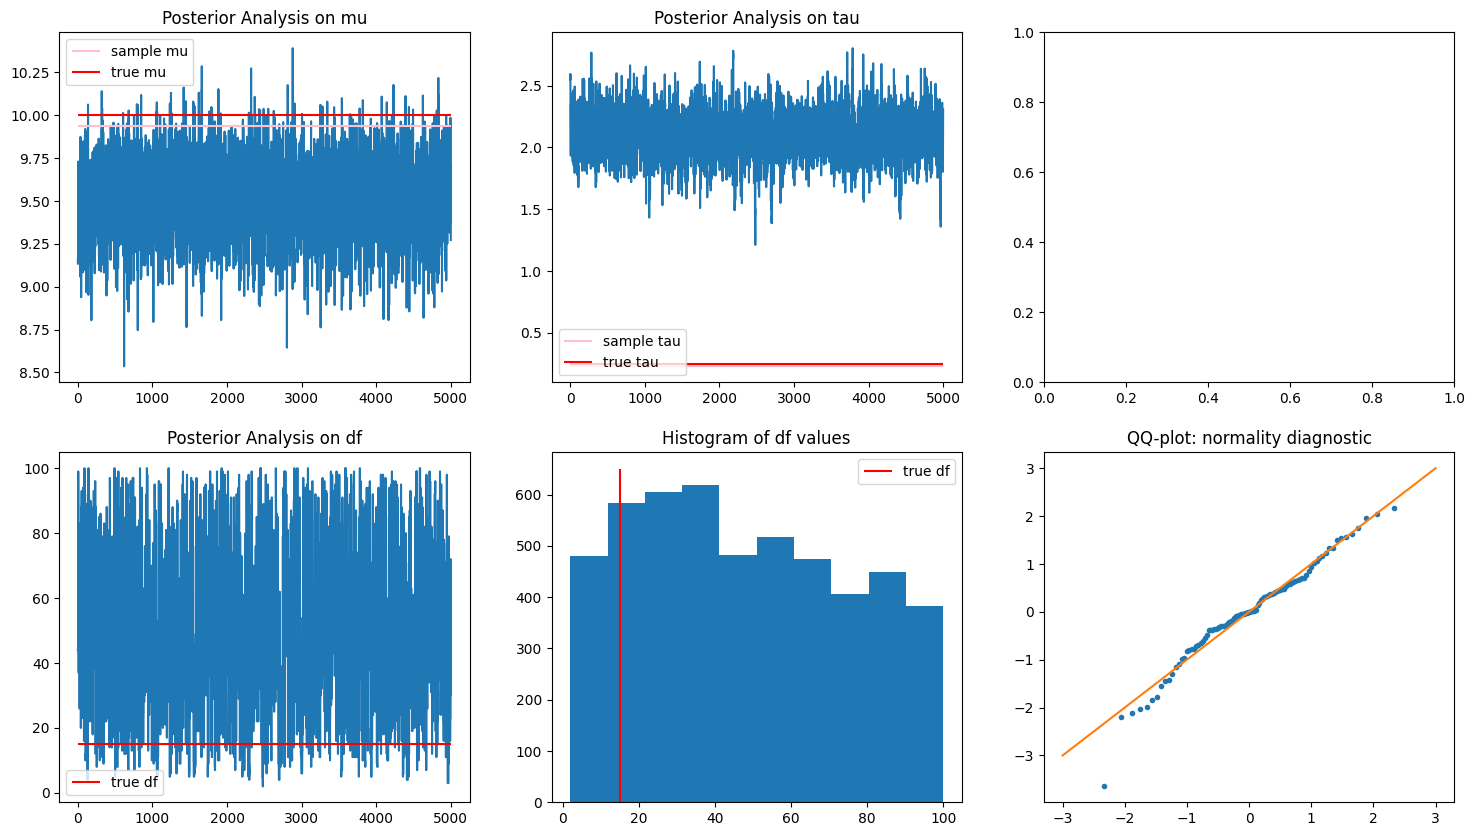

In [ ]:
from scipy.stats import gaussian_kde; import matplotlib.pyplot as plt

fig,ax = plt.subplots(2,3, figsize=(18,10))

mu_samps = idata.posterior["mu"].sel(chain=0, draw=slice(0, num_draws)).values
tau_samps = idata.posterior["tau"].sel(chain=0, draw=slice(0, num_draws)).values
v_samps = idata.posterior["v"].sel(chain=0, draw=slice(0, num_draws)).values

ax[0,0].plot(mu_samps)
ax[0,0].set_title("Posterior Analysis on mu")
ax[0,0].hlines(x.mean(), xmin=0, xmax=num_draws, label = 'sample mu', color = 'pink')
ax[0,0].hlines(mu_true, xmin=0, xmax=num_draws, label = 'true mu', color = 'red')
ax[0,0].legend()

ax[0,1].plot(tau_samps)
ax[0,1].set_title("Posterior Analysis on tau")
ax[0,1].hlines((1/x.var()), xmin=0, xmax=num_draws, label = 'sample tau', color = 'pink')
ax[0,1].hlines(tau_true, xmin=0, xmax=num_draws, label = 'true tau', color = 'red')
ax[0,1].legend()

ax[1,0].plot(v_samps)
ax[1,0].set_title("Posterior Analysis on df")
ax[1,0].hlines(df_true, xmin=0, xmax=num_draws, label = 'true df', color = 'red')
ax[1,0].legend()

ax[1,1].hist(v_samps)
ax[1,1].set_title("Histogram of df values")
ax[1,1].vlines(df_true, ymin = 0, ymax= 650, label = 'true df', color = 'red')
ax[1,1].legend()


ax[1,2].plot(stats.norm.ppf(np.linspace(0,1,n+2))[1:-1], sorted((x-x.mean())/x.std()),".")
ax[1,2].plot([-3,3],[-3,3])
ax[1,2].set_title("QQ-plot: normality diagnostic")

Now, let's play around with the sample size and see how that impacts the degrees of freedom inference

In [132]:
np.random.seed(1006693507)
#smaller sample size (n=500)
sm_x = stats.t(df = df_true, loc = mu_true, scale = sig_true).rvs(500)
with model:
  likelihood = pymc.StudentT("small likelihood", nu = v, mu = mu, lam = lam, observed = sm_x)
  smaller_idata = pymc.sample(draws = 500)

#bigger sample size (n=10 000)
l_x = stats.t(df = df_true, loc = mu_true, scale = sig_true).rvs(10000)
with model:
  likelihood = pymc.StudentT("big likelihood", nu = v, mu = mu, lam = lam, observed = l_x)
  bigger_idata = pymc.sample(draws = 10000)

#biggest sample size (n = 50 000)
xl_x = stats.t(df = df_true, loc = mu_true, scale = sig_true).rvs(50000)
with model:
  likelihood = pymc.StudentT("biggest likelihood", nu = v, mu = mu, lam = lam, observed = xl_x)
  biggest_idata = pymc.sample(draws = 50000)

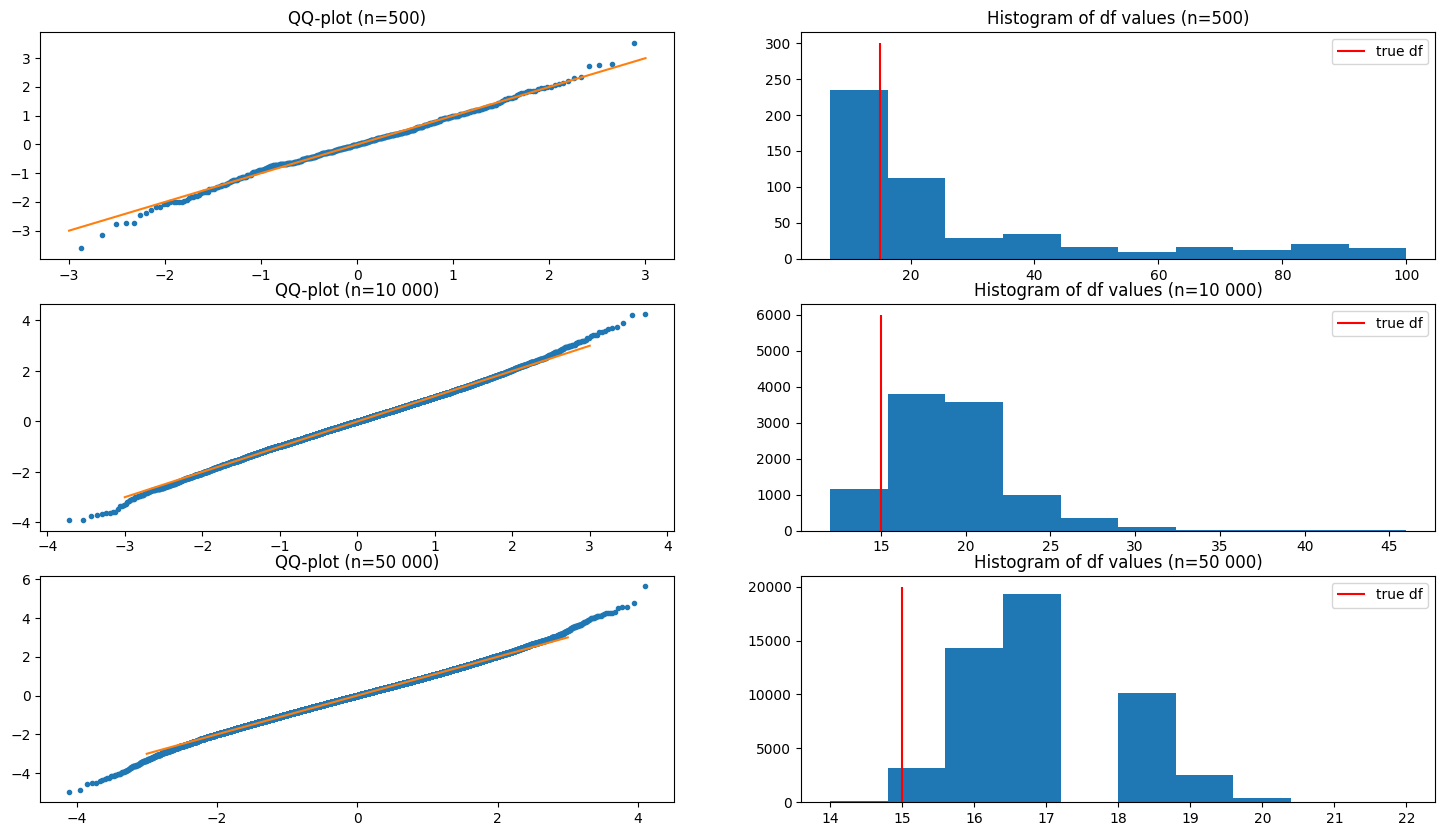

In [136]:
smaller_v_samps = smaller_idata.posterior["v"].sel(chain=0, draw=slice(0, 500)).values
bigger_v_samps = bigger_idata.posterior["v"].sel(chain=0, draw=slice(0, 10000)).values
biggest_v_samps = biggest_idata.posterior["v"].sel(chain=0, draw=slice(0, 50000)).values

fig,ax = plt.subplots(3,2, figsize=(18,10))

#Plotting smaller samps
ax[0,0].plot(stats.norm.ppf(np.linspace(0,1,502))[1:-1], sorted((sm_x-sm_x.mean())/sm_x.std()),".")
ax[0,0].plot([-3,3],[-3,3])
ax[0,0].set_title("QQ-plot (n=500)")

ax[0,1].hist(smaller_v_samps)
ax[0,1].set_title("Histogram of df values (n=500)")
ax[0,1].vlines(df_true, ymin = 0, ymax= 300, label = 'true df', color = 'red')
ax[0,1].legend()

#Plotting bigger samps
ax[1,0].plot(stats.norm.ppf(np.linspace(0,1,10002))[1:-1], sorted((l_x-l_x.mean())/l_x.std()),".")
ax[1,0].plot([-3,3],[-3,3])
ax[1,0].set_title("QQ-plot (n=10 000)")

ax[1,1].hist(bigger_v_samps)
ax[1,1].set_title("Histogram of df values (n=10 000)")
ax[1,1].vlines(df_true, ymin = 0, ymax= 6000, label = 'true df', color = 'red')
ax[1,1].legend()

#Plotting biggest samps
ax[2,0].plot(stats.norm.ppf(np.linspace(0,1,50002))[1:-1], sorted((xl_x-xl_x.mean())/xl_x.std()),".")
ax[2,0].plot([-3,3],[-3,3])
ax[2,0].set_title("QQ-plot (n=50 000)")

ax[2,1].hist(biggest_v_samps)
ax[2,1].set_title("Histogram of df values (n=50 000)")
ax[2,1].vlines(df_true, ymin = 0, ymax= 20000, label = 'true df', color = 'red')
ax[2,1].legend()

The main change regarding the v parameter seems to be the range of likely values, which decreases as the sample size goes up (the smallest sample size has the widest range of predicted degrees of freedom, while the largest sample size's predictions are fairly tightly contained between 15 and 20). All estimates are skewed to the larger side and the simulated data for all cases looks normal by the QQ Plot. To get that tighter estimate, I needed 50,000 samples.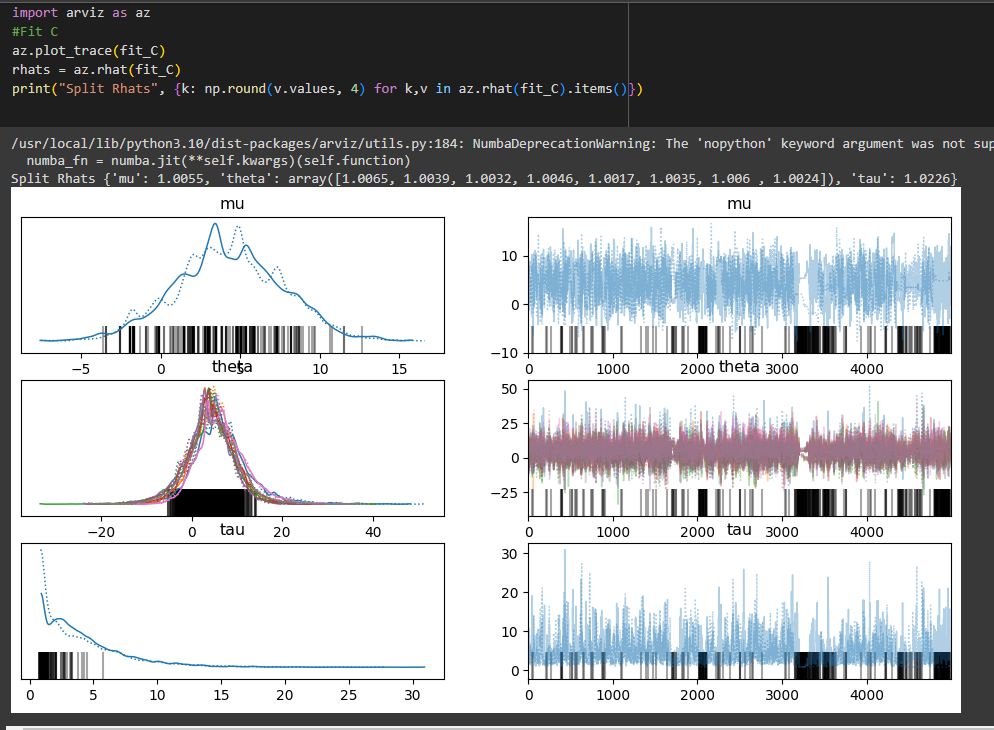

# Part 2


In [ ]:
#A - Effective Sample Size
print("Number of samples", idata.posterior['mu'].values.flatten().shape[-1])
az.summary(idata, round_to =2)

Number of samples 10000


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,9.53,0.22,9.12,9.96,0.00,0.00,4903.18,6295.83,1.00
v,41.85,24.47,3.00,85.00,7.08,5.14,12.96,85.46,1.11
tau,2.07,0.19,1.70,2.44,0.02,0.01,148.27,222.45,1.01


Looking at the results above (specifically the ess_bulk code), it shows taht we're working with an effective sample size of approximately:


*   4903.18 for mu
*   12.96 for degrees of freedom (v)
*   148.27 for tau

All with reference to 6000 samples taken




Split Rhats {'mu': 1.0011, 'v': 1.1081, 'tau': 1.0136}


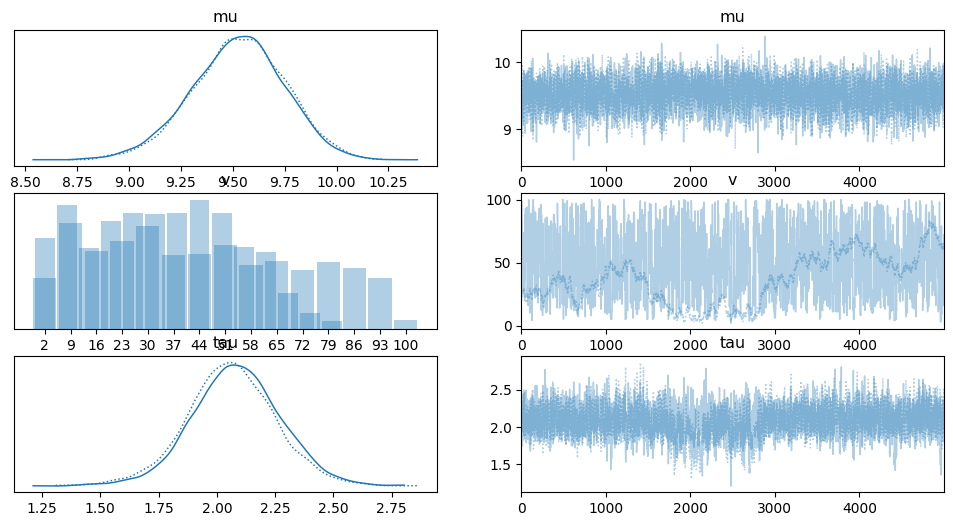

In [ ]:
#B - Chain convergence measures
az.plot_trace(idata)

rhats = az.rhat(idata)

print("Split Rhats", {k: np.round(v.values, 4) for k,v in az.rhat(idata).items()})

The analysis above implies that the tau and mu parameters have converged - their split-rhat values are under 1.05 and different iterations of each parameter's trace plots look similar to each other.

However, the split-rhat value for the degrees of freedom is a fair amount above 1.05 at 1.1081, implying that parameter has not yet reached convergence in the "idata" dataset.

**C : Divergences**

No divergences were reported by R when sampling from the model.

(array([ 148.,  120.,  157.,  222.,  333.,  451.,  711., 1022., 1687.,
        5149.]),
 array([4.79302195e-10, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]),
 <BarContainer object of 10 artists>)

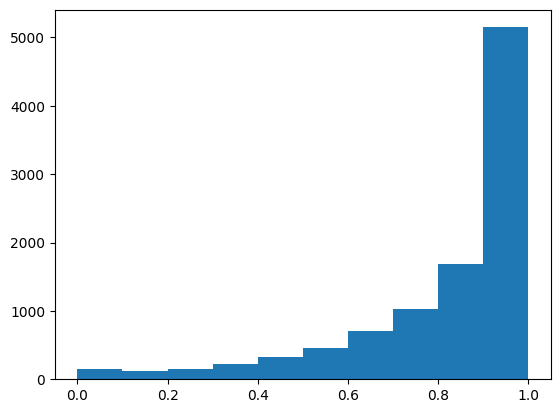

In [138]:
#D : Metropolis-Hastings Acceptance Rates
plt.hist(idata.sample_stats.acceptance_rate.values.flatten())

The heavy left skew implies a high acceptance rate and a good parametrization in the model.

**E : Other Warnings and Concerns from PyMc**

No other warnings or concerns from PyMc

# Part 2: Eight Schools

These comments are all made in reference to the following document: https://github.com/pointOfive/STA410_W24_StatisticalComputation/blob/main/Week3/STA410_W24_Week3_Demo_HMCwithPyMC.ipynb

**A : Effective Sample Size**

Based on the table labeled "Effective Sample Sizes (function of Markov Chain autocorrelation dependency)", the Non-Centered version has substantially higher effective sample sizes than the Centered version (the smallest difference is 8847 observations). This implies that the Non-Centered algorithm is more computationally efficient.

**B : Chain Convergence Measures**

Using the models from the document (see below), I created traceplots and calculated the split r-hat values. Though the centered model's split r-hat values are all under 1.05, the trace plots look wonky and mismatched, implying they have not converged yet. For the non-centered version, the trace plots seem to agree a lot more and the split r-hat values are also below 1.05.


**C : Divergences**

Using the centered model, the first sampling chain reported 71 divergences and the second sampling chain reported 283 divergences. Using the non-centered model, the first sampling chain reported 5 divergences and the second reported 3 divergences. This shows that the centered model is having a harder time sampling from our target distribution than the non-centered model, implying that for both accuracy and computational efficiency, the non-centered model is preferable.

**D: Metropolis-Hastings Acceptance Rates**

Looking at the chunk of code noted as "In [47]" in the document and its corresponding graph, the non-centered version has substantially higher Metropolis-Hastings acceptance rates (shown by the long left tail and the density of observations around 1), while the centered version has more observations around 0. This implies that the non-centered version is a better parametrization than the centered version

**E: Other PyMc Warnings**

The Centered model produced the following messages:

*INFO:pymc.sampling.mcmc:Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 33 seconds. INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics*

The model only runs two chains, so this implies that more chains should be added to be sure of convergence in this model.

The Non-Centered model produced the following messages:

*INFO:pymc.sampling.mcmc:Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 20 seconds. INFO:pymc.stats.convergence:We recommend running at least 4 chains for robust computation of convergence diagnostics*

Again, this model should run four sampling chains to be sure of convergence. The difference in run-time between the Centered model and the Non-Centered model again confirms that the Non-Cetnered model is more efficient

In [140]:
J = 8
y = np.array([28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0])
sigma = np.array([15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0])

with pymc.Model() as Centered_eight:

    # We assume the following prior distributions for our parameters
    mu = pymc.Normal("mu", mu=0, sigma=5)
    tau = pymc.HalfCauchy("tau", beta=5)

    # and we assume the following probabilistic hierarchy
    # within the data generating mechanism
    theta = pymc.Normal("theta", mu=mu, sigma=tau, shape=J) # theta is length J=8

    # Note that if tau was small, then the density evalution above
    # could change rapidly for changes in theta
    # This means that the energy has high curvature

    # likelihood where observed information enters into the model
    obs = pymc.Normal("obs", mu=theta, sigma=sigma, observed=y)

SEED = [20100420, 20134234] # random seeds for each of two run HMC chains
with Centered_eight:
    fit_C = pymc.sample(5000, chains=2, tune=1000, random_seed=SEED,
                      return_inferencedata=True, idata_kwargs={"log_likelihood": True})

with pymc.Model() as NonCentered_eight:

    mu = pymc.Normal("mu", mu=0, sigma=5)
    tau = pymc.HalfCauchy("tau", beta=5)
    theta_tilde = pymc.Normal("theta_t", mu=0, sigma=1, shape=J)
    # Changes in theta now take place on a fixed scale that is independent of tau

    theta = pymc.Deterministic("theta", mu + tau * theta_tilde)
    # Changes in tau can still result in rapid changes in the density evaluations
    # below so the energy still has high curvature with respect to tau; but,
    # it no longer has high curvature with respect to theta
    obs = pymc.Normal("obs", mu=theta, sigma=sigma, observed=y)

with NonCentered_eight:
    fit_NC = pymc.sample(5000, chains=2, tune=1000, random_seed=SEED,
                       return_inferencedata=True, idata_kwargs={"log_likelihood": True})
# Now very few divergences... problem solved!

Split Rhats {'mu': 1.0055, 'theta': array([1.0065, 1.0039, 1.0032, 1.0046, 1.0017, 1.0035, 1.006 , 1.0024]), 'tau': 1.0226}


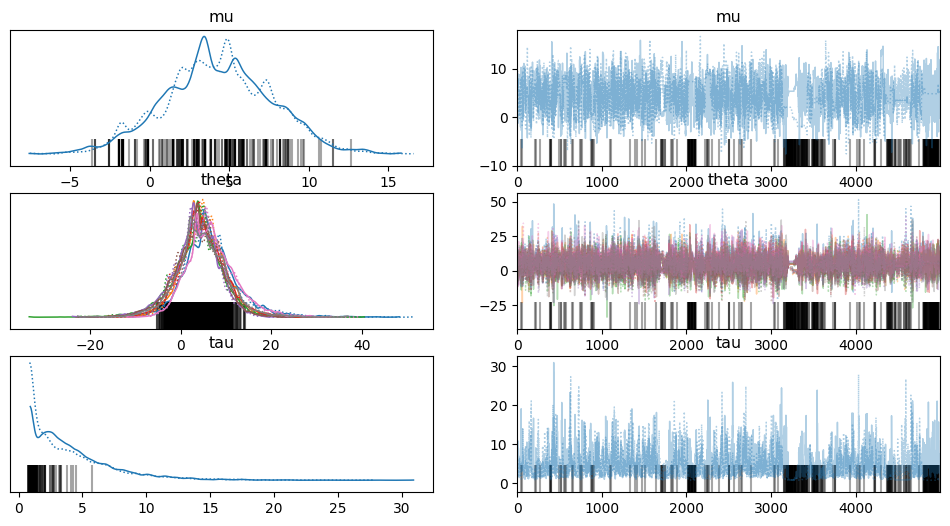

In [143]:
#Fit C
az.plot_trace(fit_C)
rhats = az.rhat(fit_C)
print("Split Rhats", {k: np.round(v.values, 4) for k,v in az.rhat(fit_C).items()})

Split Rhats {'mu': 1.0001, 'theta_t': array([1.0001, 1.0002, 1.    , 0.9999, 1.0002, 1.    , 1.0001, 1.0016]), 'tau': 1.0001, 'theta': array([1.0002, 1.0002, 1.    , 1.0006, 1.0007, 0.9999, 0.9999, 1.    ])}


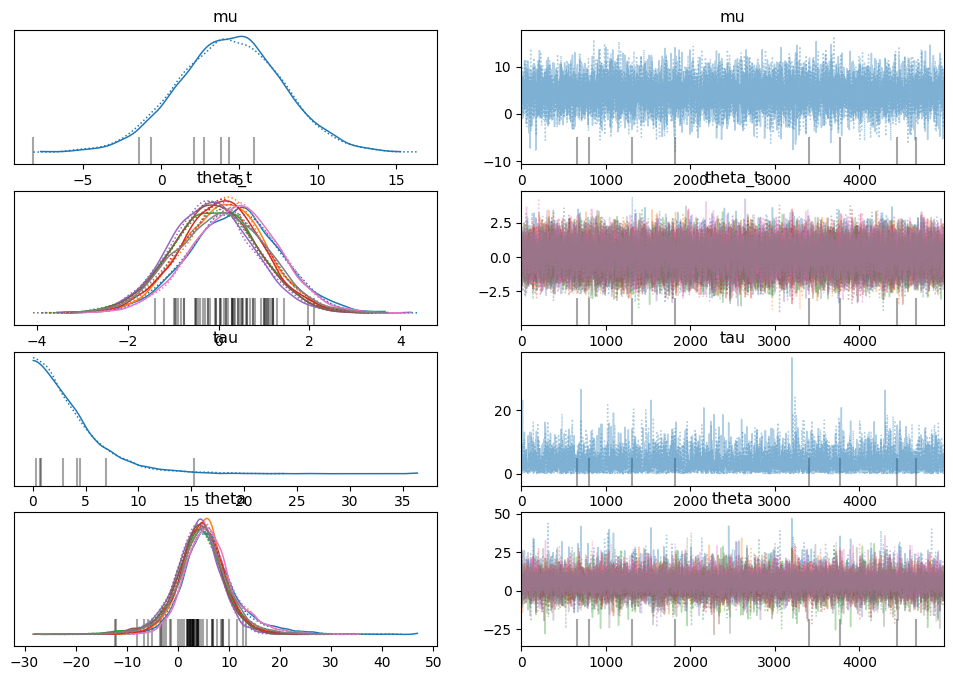

In [142]:
#Fit NC
az.plot_trace(fit_NC)
rhats = az.rhat(fit_NC)
print("Split Rhats", {k: np.round(v.values, 4) for k,v in az.rhat(fit_NC).items()})

**From the perspective of curvature of the energy function (that is, how rapidly the log joint posterior distribution density changes for different values of its random variable (parameters) and the effectiveness of the HMC algorithm, explain why the "uncentered" paramterization of the model performs better than the "centered" parameterization**

The main reasons why the uncentered parametrization of the energy function performs better than the centered version are:

1. Larger effective sample size by a large margin (so we're getting more analytical bang for our buck computationally)
2. Fewer divergences (again, more computationally efficient and more accurate because it isn't "flying off" so much)
3. Higher Metropolis-Hastings acceptance rate (we aren't wasting a bunch of time and computational power making proposing samples that will never be accepted)

# Part 2: Observed Energy Proposal Distribution vs Empirical Energy Distribution

In the top plot, the one for the Centered parametrization, the two curves look very distinctly different, which implies that the NUTS algorithm was not able to adequately explore the posterior distribution and that, therefore, estimates from the model's posterior may be biased. Conversely, the energy graphs for the Non-Centered parametrization look very similar, implying the posterior was adequately explored and the samples from that posterior will not be biased. This diagnostic supports my previous conclusions that the Non-Centered algorithm is the better algorithm, both for accuracy and computational efficiency.

<Axes: >

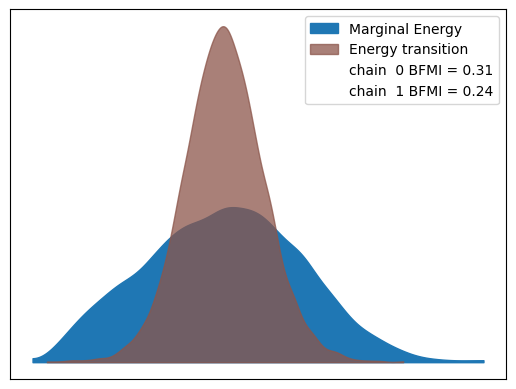

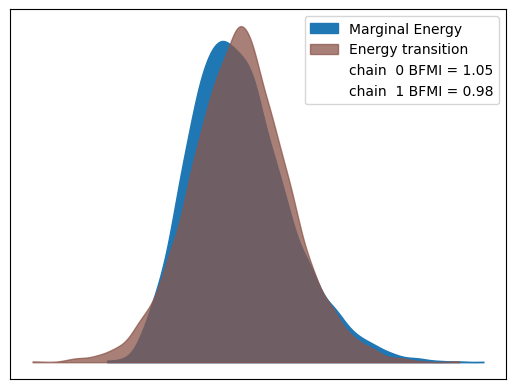

In [144]:
az.plot_energy(fit_C);
az.plot_energy(fit_NC)